# tdsm encoder
Here provides the interface of interacting with function in `util` to perform the training & sampling of generative model. 

## import model

In [1]:
import time, functools, torch, os,sys, random, fnmatch, psutil
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam,RAdam
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import trans_tdsm, utils
from prettytable import PrettyTable
import util.dataset_structure, util.display, util.model
import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
padding_value = -20

dataset = "dataset_1_photons_padded_nentry"
dataset_store_path = "/eos/user/j/jthomasw/tdsm_encoder/datasets/test/"
transform = None
transform_y = None
mask = True
jupyternotebook = True

workingdir = "./"
### HYPERPARAMETERS ###
train_ratio = 0.9
batch_size = 64
lr = 0.00001
n_epochs = 5
### SDE PARAMETERS ###
SDE = 'VE'
sigma_max = 50.
### MODEL PARAMETERS ###
n_feat_dim = 4
embed_dim = 512
hidden_dim = 128
num_encoder_blocks = 3
num_attn_heads = 8
dropout_gen = 0

# Instantiate stochastic differential equation
if SDE == 'VP':
    sde = utils.VPSDE(beta_max=sigma_max,device=device)
if SDE == 'VE':
    sde = utils.VESDE(sigma_max=sigma_max,device=device)
marginal_prob_std_fn = functools.partial(sde.marginal_prob)
diffusion_coeff_fn = functools.partial(sde.sde)

print('torch version: ', torch.__version__)
print('Running on device: ', device)
if torch.cuda.is_available():
    print('Cuda used to build pyTorch: ',torch.version.cuda)
    print('Current device: ', torch.cuda.current_device())
    print('Cuda arch list: ', torch.cuda.get_arch_list())

print('Working directory: ', workingdir)

files_list_ = []
for filename in os.listdir(dataset_store_path):
    if fnmatch.fnmatch(filename, dataset + '12*.pt'):
        files_list_.append(os.path.join(dataset_store_path, filename))
print(files_list_)

model=trans_tdsm.Gen(n_feat_dim, embed_dim, hidden_dim, num_encoder_blocks, num_attn_heads, dropout_gen, marginal_prob_std=marginal_prob_std_fn)

table = PrettyTable(['Module name', 'Parameters listed'])
t_params = 0
for name_ , para_ in model.named_parameters():
    if not para_.requires_grad: continue
    param = para_.numel()
    table.add_row([name_, param])
    t_params+=param
print(table)
print(f'Sum of trainable parameters: {t_params}')    

torch version:  1.11.0a0+gitbc2c6ed
Running on device:  cuda
Cuda used to build pyTorch:  11.2
Current device:  0
Cuda arch list:  ['sm_37', 'sm_50', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'compute_37']
Working directory:  ./
['/eos/user/j/jthomasw/tdsm_encoder/datasets/test/dataset_1_photons_padded_nentry121To150.pt']
+--------------------------------+-------------------+
|          Module name           | Parameters listed |
+--------------------------------+-------------------+
|           cls_token            |        512        |
|          embed.weight          |        2048       |
|           embed.bias           |        512        |
|        embed_t.1.weight        |       262144      |
|         embed_t.1.bias         |        512        |
|      dense1.dense.weight       |        512        |
|       dense1.dense.bias        |         1         |
| encoder.0.attn.in_proj_weight  |       786432      |
|  encoder.0.attn.in_proj_bias   |        1536       |
| encoder.0.attn.out_p

## Plot data distribution (Optional)

filename: /eos/user/j/jthomasw/tdsm_encoder/datasets/test/dataset_1_photons_padded_nentry121To150.pt
Plot # entries
Plot incident energies
Plot hit energies
Plot hit x
Plot hit y
Plot hit z


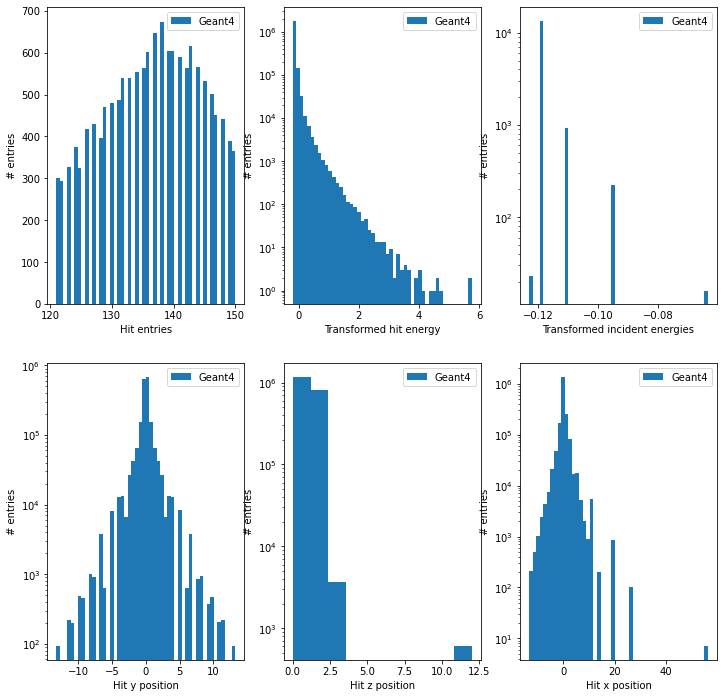

In [2]:
fig = util.display.plot_distribution(files_list_, label="Geant4")
fig.show()

## Training

  0%|          | 0/5 [00:00<?, ?it/s]

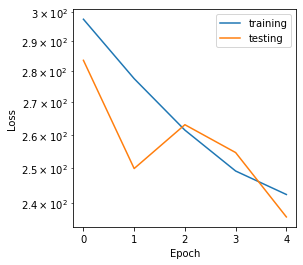

['/eos/user/j/jthomasw/tdsm_encoder/datasets/test/dataset_1_photons_padded_nentry121To150.pt']
Training
Testing
Training
Testing
Training
Testing
Training
Testing
Training
Testing


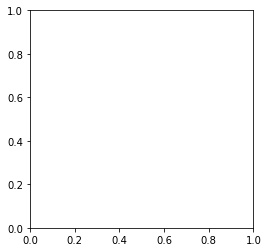

In [6]:
output_directory = workingdir+'/training_'+datetime.now().strftime('%Y%m%d_%H%M')+'_output/'
if not os.path.exists(output_directory):
            os.makedirs(output_directory)
optimiser = RAdam(model.parameters(),lr=lr)
av_training_losses_per_epoch = []
av_testing_losses_per_epoch = []

fig, ax = plt.subplots(ncols=1, figsize=(4,4))
epochs = tqdm.notebook.trange(n_epochs)
from IPython import display
dh = display.display(fig, display_id=True)

files_list_ = []
for filename in os.listdir(dataset_store_path):
    if fnmatch.fnmatch(filename, dataset + '12*.pt'):
        files_list_.append(os.path.join(dataset_store_path, filename))
print(files_list_)

for epoch in epochs:

    # Create/clear per epoch variables
    cumulative_epoch_loss = 0.
    cumulative_test_epoch_loss = 0.

    file_counter = 0
    n_training_showers = 0
    n_testing_showers = 0
    training_batches_per_epoch = 0
    testing_batches_per_epoch = 0

    # Load files
    for filename in files_list_:

        custom_data = utils.cloud_dataset(filename, device=device)
        train_size = int(0.9 * len(custom_data.data))
        test_size = len(custom_data.data) - train_size
        train_dataset, test_dataset = torch.utils.data.random_split(custom_data, [train_size, test_size])

        n_training_showers+=train_size
        n_testing_showers+=test_size
        # Load clouds for each epoch of data dataloaders length will be the number of batches
        shower_loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        shower_loader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
        
        # Accumuate number of batches per epoch
        training_batches_per_epoch += len(shower_loader_train)
        testing_batches_per_epoch += len(shower_loader_test)
        
        # Load shower batch for training
        for i, (shower_data,incident_energies) in enumerate(shower_loader_train,0):
            # Move model to device and set dtype as same as data (note torch.double works on both CPU and GPU)
            model.to(device, shower_data.dtype)
            model.train()
            shower_data = shower_data.to(device)
            incident_energies = incident_energies.to(device)
            
            if len(shower_data) < 1:
                print('Very few hits in shower: ', len(shower_data))
                continue
            # Zero any gradients from previous steps
            optimiser.zero_grad()
            # Loss average for each batch
            loss = trans_tdsm.loss_fn(model, shower_data, incident_energies, marginal_prob_std_fn, device=device)
            # Accumulate batch loss per epoch
            cumulative_epoch_loss+=float(loss)
            # collect dL/dx for any parameters (x) which have requires_grad = True via: x.grad += dL/dx
            #loss.backward(retain_graph=True)
            loss.backward()
            # Update value of x += -lr * x.grad
            optimiser.step()
            
        # Testing on subset of file
        for i, (shower_data,incident_energies) in enumerate(shower_loader_test,0):
            with torch.no_grad():
                model.eval()
                shower_data = shower_data.to(device)
                incident_energies = incident_energies.to(device)
                test_loss = trans_tdsm.loss_fn(model, shower_data, incident_energies, marginal_prob_std_fn, device=device)
                cumulative_test_epoch_loss+=float(test_loss)
    
    # Calculate average loss per epoch
    av_training_losses_per_epoch.append(cumulative_epoch_loss/training_batches_per_epoch)
    av_testing_losses_per_epoch.append(cumulative_test_epoch_loss/testing_batches_per_epoch)
    epochs.set_description('Average Loss: {:5f}(Train) {:5f}(Test)'.format(cumulative_epoch_loss/training_batches_per_epoch, cumulative_test_epoch_loss/testing_batches_per_epoch))
    fig, ax = plt.subplots(ncols=1, figsize=(4,4))
    plt.title('')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.yscale('log')
    plt.plot(av_training_losses_per_epoch, label='training')
    plt.plot(av_testing_losses_per_epoch, label='testing')
    plt.legend(loc='upper right')
    dh.update(fig)
    if epoch == len(epochs):
        fig.savefig(output_directory+'loss_v_epoch.png')
    plt.close(fig)

torch.save(model.state_dict(), output_directory+'ckpt_tmp_'+str(epoch)+'.pth')


## Sampling 

Max hits taken from ['/eos/user/j/jthomasw/tdsm_encoder/datasets/test/dataset_1_photons_padded_nentry121To150.pt']


/eos/home-i01/j/jthomasw/tdsm_encoder/trans_tdsm.py:371: RuntimeWarning:

invalid value encountered in true_divide



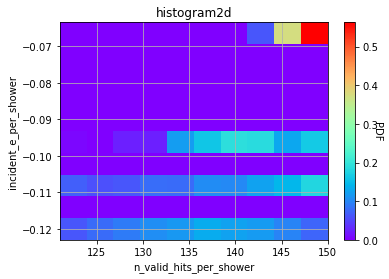

in_energies: tensor([14.7643, 28.3953,  6.0099, 27.2845, 23.9453, 21.4988,  9.3789, 18.9909,
        15.7352,  5.3336, 20.1672, 25.3718, 10.2178, 22.7975, 28.4820, 15.8834,
        20.1236, 12.3433, 21.2529, 24.5652, 29.0082,  6.0044, 16.6612, 14.0531,
         6.8974,  0.8468,  0.0541, 28.7460, 14.7647, 16.0126, 23.1294,  2.2763,
         7.9036, 23.5481, 12.3699,  9.6117,  7.6495,  3.2061, 25.8962, 12.1923,
         8.3975, 10.5019, 19.2452, 20.6958,  5.5843,  6.6823, 24.2205, 28.4199,
        17.2572,  7.3477, 17.6769, 27.9437, 22.3514, 12.5388,  5.1171,  2.6252,
        12.3296, 24.2640,  8.4102, 16.0671, 28.8163, 21.4044, 19.7709,  4.6693,
        17.1589, 15.3588, 26.1276,  1.6840,  5.3162,  8.7368, 19.6507,  2.9275,
         9.0325,  2.5670,  6.2651, 27.4606, 17.0961, 26.8459,  1.4260, 16.2221,
         1.1402, 23.8400,  1.7524,  1.5283, 28.6187,  9.5304,  2.5289, 25.7959,
        13.6935, 23.5299, 10.0299, 23.8343,  7.6092,  8.6864, 14.0619,  6.0091,
        16.0593, 18.8955, 1

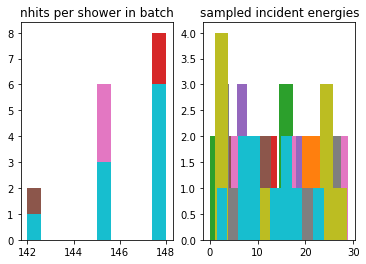

Generation batch 0: showers per batch: 10, max. hits per shower: 148, features per hit: 4, sampled_energies: 10
Progress: 1/10

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([10, 148, 4])
Generation batch 1: showers per batch: 10, max. hits per shower: 148, features per hit: 4, sampled_energies: 10
Progress: 2/10

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([20, 148, 4])
Generation batch 2: showers per batch: 10, max. hits per shower: 148, features per hit: 4, sampled_energies: 10
Progress: 3/10

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([30, 148, 4])
Generation batch 3: showers per batch: 10, max. hits per shower: 148, features per hit: 4, sampled_energies: 10
Progress: 4/10

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([40, 148, 4])
Generation batch 4: showers per batch: 10, max. hits per shower: 148, features per hit: 4, sampled_energies: 10
Progress: 5/10

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([50, 148, 4])
Generation batch 5: showers per batch: 10, max. hits per shower: 148, features per hit: 4, sampled_energies: 10
Progress: 6/10

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([60, 148, 4])
Generation batch 6: showers per batch: 10, max. hits per shower: 148, features per hit: 4, sampled_energies: 10
Progress: 7/10

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([70, 148, 4])
Generation batch 7: showers per batch: 10, max. hits per shower: 148, features per hit: 4, sampled_energies: 10
Progress: 8/10

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([80, 148, 4])
Generation batch 8: showers per batch: 10, max. hits per shower: 148, features per hit: 4, sampled_energies: 10
Progress: 9/10

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([90, 148, 4])
Generation batch 9: showers per batch: 10, max. hits per shower: 148, features per hit: 4, sampled_energies: 10
Progress: 10/10

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([100, 148, 4])


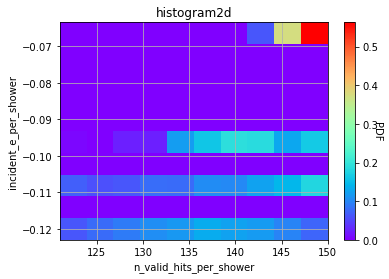

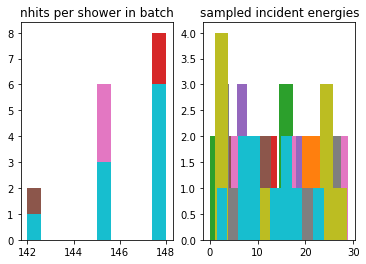

In [7]:
from IPython import display
from datetime import datetime
import functools, torch, os, sys, random
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import tqdm
workingdir = "./"

# SAMPLE PARAMETERS
n_sampler_calls = 100
sampler_steps = 100

output_directory = workingdir+'/sampling_'+str(sampler_steps)+'samplersteps_'+datetime.now().strftime('%Y%m%d_%H%M')+'_output/'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Load saved model
model.load_state_dict(torch.load('training_20230707_1714_output/ckpt_tmp_4.pth', map_location=device))
model.to(device)

# Get max. N hits / N valid hits in batch
n_valid_hits_per_shower = []
incident_e_per_shower = []
max_hits = -1
print(f'Max hits taken from {files_list_}')
for file in files_list_:
    # Load shower data
    custom_data = utils.cloud_dataset(file, device=device)
    point_clouds_loader = DataLoader(custom_data, batch_size=batch_size, shuffle=False)
    # Loop over batches
    for i, (shower_data, incident_energies) in enumerate(point_clouds_loader,0):

        # Copy data
        valid_event = []
        data_np = shower_data.cpu().numpy().copy()
        energy_np = incident_energies.cpu().numpy().copy()

        # Mask for padded values
        masking = data_np[:,:,0] != -20
        # Loop over each shower in batch
        for j in range(len(data_np)):
            # Mask padded hits and count valid hits for shower j in batch
            valid_hits = data_np[j][masking[j]]
            n_valid_hits_per_shower.append(len(valid_hits))
            if len(valid_hits)>max_hits:
                max_hits = len(valid_hits)
            incident_e_per_shower.append(energy_np[j])
    del custom_data

# Arrays of Nvalid hits in showers, incident energies per shower
n_valid_hits_per_shower = np.array(n_valid_hits_per_shower)
incident_e_per_shower = np.array(incident_e_per_shower)

# Generate 2D pdf of incident E vs N valid hits from the training file(s)
n_bins_prob_dist = 10
e_vs_nhits_prob, x_bin, y_bin = trans_tdsm.get_prob_dist(incident_e_per_shower, n_valid_hits_per_shower, n_bins_prob_dist)

fig0, (ax0) = plt.subplots(ncols=1, sharey=True)
dh0 = display.display(fig0, display_id=True)

heatmap = ax0.pcolormesh(y_bin, x_bin, e_vs_nhits_prob, cmap='rainbow')
ax0.plot(n_valid_hits_per_shower, n_valid_hits_per_shower, 'k-')
ax0.set_xlim(n_valid_hits_per_shower.min(), n_valid_hits_per_shower.max())
ax0.set_ylim(incident_e_per_shower.min(), incident_e_per_shower.max())
ax0.set_xlabel('n_valid_hits_per_shower')
ax0.set_ylabel('incident_e_per_shower')
cbar = plt.colorbar(heatmap)
cbar.ax.set_ylabel('PDF', rotation=270)
ax0.set_title('histogram2d')
ax0.grid()

dh0.update(fig0)

# Tensor of random incident energies
n_showers_2_gen =  100
in_energies = torch.rand(n_showers_2_gen)*30 # can alter multiplicative factor to vary the appropriate range of injection energies

# Sample from 2D pdf -> nhits per shower vs incident energies
nhits, gen_hits = trans_tdsm.generate_hits(e_vs_nhits_prob, x_bin, y_bin, in_energies, max_hits, 4, device=device)
# Save random
torch.save([gen_hits, in_energies],'tmp.pt')
gen_hits = utils.cloud_dataset('tmp.pt', device=device)
gen_hits.padding(padding_value)
os.system("rm tmp.pt")
sample = []
batch_size=10
gen_hits_loader = DataLoader(gen_hits, batch_size=batch_size, shuffle=False)

fig1, (ax2,ax3) = plt.subplots(nrows=1,ncols=2,)
dh = display.display(fig1, display_id=True)
ax2.set_title('nhits per shower in batch')
ax3.set_title('sampled incident energies')
# Loop over each batch
for i, (gen_hit, sampled_energies) in enumerate(gen_hits_loader,0):
    print(f'Generation batch {i}: showers per batch: {gen_hit.shape[0]}, max. hits per shower: {gen_hit.shape[1]}, features per hit: {gen_hit.shape[2]}, sampled_energies: {len(sampled_energies)}')    
    sys.stdout.write('\r')
    sys.stdout.write("Progress: %d/%d" % ((i+1), len(gen_hits_loader)))
    sys.stdout.flush()
    
    if jupyternotebook == True:
        valid_hits = []
        sampled_energies_ = []
        # Loop over showers in batch
        for shower_idx in range(0,gen_hit.shape[0]):
            valid_hits_ = (gen_hit[shower_idx]!=-20).sum() / 4
            valid_hits.append( valid_hits_.item() )
            sampled_energies_.append(sampled_energies[shower_idx].item())
        
        ax2.hist(valid_hits, label='nhits')
        ax3.hist(sampled_energies_, label='GeV')
        dh.update(fig1)
    
    # Generate a sample
    generative = trans_tdsm.pc_sampler(model, marginal_prob_std_fn, diffusion_coeff_fn, sampled_energies, gen_hit, batch_size=gen_hit.shape[0], snr=0.16, sampler_steps=sampler_steps, device=device, jupyternotebook=True)
    
    if i == 0:
        sample = generative
    else:
        sample = torch.cat([sample,generative])
    
    print(f'sample: {sample.shape}')
        
sample_ = []
sample_np = sample.cpu().numpy()

for i in range(len(sample_np)):
    tmp_sample = sample_np[i][:nhits[i]]
    sample_.append(torch.tensor(tmp_sample))
torch.save([sample_,in_energies], os.path.join(output_directory, 'sample.pt'))


## Draw Generative Distribution

Plot # entries
Plot incident energies
Plot hit energies
Plot hit x
Plot hit y
Plot hit z


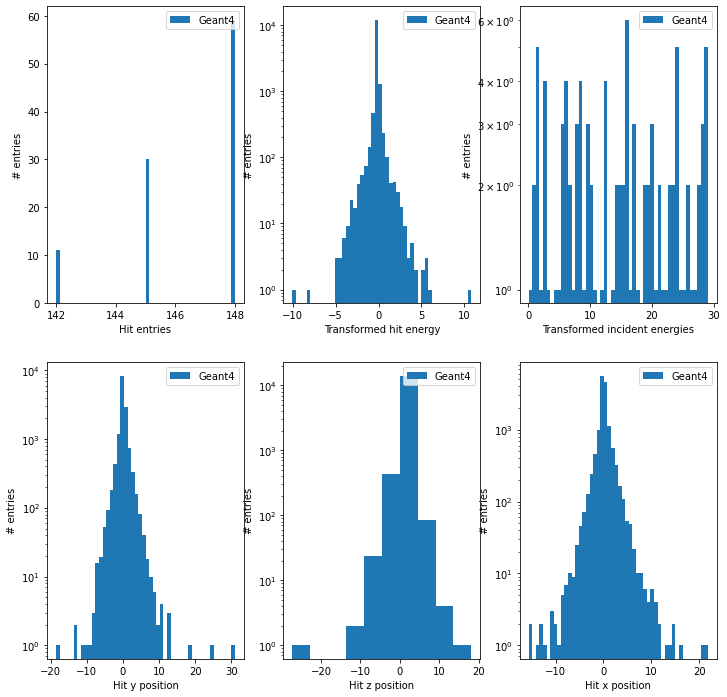

In [3]:
output_directory = 'sampling_100samplersteps_20230707_1717_output'
plot_file_name = os.path.join(output_directory, 'sample.pt')

custom_data = utils.cloud_dataset(plot_file_name,device=device)
#custom_data.padding()
fig = util.display.plot_distribution(custom_data, label="Geant4")
fig.show()


#fig = util.display.plot_distribution([plot_file_name], label="Geant4")
#fig.show()
